In [81]:
import xml.etree.ElementTree as etree
import json
import os
import pdb
import json
import re
import pdb
import numpy as np
import os
import pickle
import spacy
import contractions

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from glob import glob
from datetime import datetime
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
from empath import Empath
from nrclex import NRCLex
from LeXmo import LeXmo

from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse

In [188]:
data_folder = 'data'
data_json_path = os.path.join(data_folder, 'full_data.json')

def extract_xml_data(xml_path, cases_folder, label_id):
    with open(xml_path) as fin:
        content = fin.read()
        tree = etree.fromstring(content)

    dataset = []
    acc_text = ''
    acc_date_list = []
    
    for i, elem in enumerate(tree.findall('WRITING')):
        text = elem.find('TEXT').text.strip()
        acc_text += text + ' '

        date = elem.find('DATE').text.strip()
        acc_date_list.append(date)

        if (i + 1) % 100 == 0:
            dataset.append({
                "text": acc_text,
                "dates": acc_date_list,
                "label": label_id
            })
            acc_text = ''
            acc_date_list = []

    if len(acc_text) > 0:
      dataset.append({
          "text": acc_text,
          "dates": acc_date_list,
          "label": label_id
      })

    return dataset

def main():
    dataset = {}
    cases_folders = ["2017_cases", "2018_cases"]
    for cases_folder in cases_folders:
        for label_id, folder_label in enumerate(['neg', 'pos']):
            xml_re = os.path.join(data_folder, cases_folder, folder_label, '*.xml')
            xlm_paths = glob(xml_re)
            
            for i, xml_path in enumerate(xlm_paths):
                xml_subject = os.path.basename(xml_path)
                dataset.update({
                    xml_subject: extract_xml_data(xml_path, cases_folder, label_id)
                })
                print(f"Collecting progress {xml_re}: {i}/{len(xlm_paths)}", end="\r")
            print()

    with open(data_json_path, 'w') as fout:
        json.dump(dataset, fout, indent=4, sort_keys=True)

main()
with open(data_json_path, 'r') as fin:
    dataset = json.load(fin)

In [189]:
antidepressant = os.path.join(data_folder, "antidepressants.txt")
three_grams = os.path.join(data_folder, "3-grams_suicide.txt")
five_grams = os.path.join(data_folder, "5-grams_suicide.txt")
over_generalization = os.path.join(data_folder, "over_generalization.txt")
psychoactive_drugs = os.path.join(data_folder, "psychoactive_drugs.txt")
unpleasant_feeling = os.path.join(data_folder, "unpleasant_feeling.txt") 
nssi_words = os.path.join(data_folder, "nssi_words.txt")

with open(antidepressant, "r") as f:
    antidepressant_list = f.read().split("\n")
    
with open(three_grams, "r") as f:
    three_grams_list = f.read().split("\n")
    
with open(five_grams, "r") as f:
    five_grams_list = f.read().split("\n")
    
with open(over_generalization, "r") as f:
    over_generalization_list = f.read().split("\n")
    
with open(psychoactive_drugs, "r") as f:
    psychoactive_drug_list = f.read().split("\n")
    
with open(unpleasant_feeling, "r") as f:
    unpleasant_feeling_list = f.read().split("\n")
    
with open(nssi_words, "r") as f:
    nssi_list = f.read().split("\n")
    
temporal_past = ["yesterday", "last", "before", "ago", "past", "back", "earlier", "later"]

In [190]:
def posting_time_level(dates):
    count = 0
    for date in dates:
        if date.time().hour >= 0 and date.time().hour <= 7:
            count += 1
    return count

def split_on_window(sequence, limit=4):
    results = []
    split_sequence = sequence.lower().split()
    iteration_length = len(split_sequence) - (limit - 1)
    max_window_indicies = range(iteration_length)
    for index in max_window_indicies:
        results.append(' '.join(split_sequence[index:index + limit]))
    return results

def count_depressive_terms(text):
    antidepress_count = len([sentence for sentence in text.split() if sentence.lower() in antidepressant_list])
    three_grams_count = len([sentence for sentence in split_on_window(text, 3) if sentence in three_grams_list])
    five_grams_count = len([sentence for sentence in split_on_window(text, 5) if sentence in five_grams_list])
    overgeneralization_count = len([sentence for sentence in text.split() if sentence.lower() in over_generalization_list])
    psychoactive_count = len([sentence for sentence in text.split() if sentence.lower() in psychoactive_drug_list])
    unpleasant_feel_count = len([sentence for sentence in text.split() if sentence.lower() in unpleasant_feeling_list])
    nssi_count = len([sentence for sentence in text.split() if sentence.lower() in nssi_list])
    temporal_count = len([sentence for sentence in text.split() if sentence.lower() in temporal_past])
    
    return antidepress_count, three_grams_count, five_grams_count, overgeneralization_count, psychoactive_count, unpleasant_feel_count, nssi_count, temporal_count

def features_pipeline(dates, text):
    
    
    words_count = len(text.split())
    punct_count = text.count('.') + text.count(',') + text.count(';') + text.count(':') + text.count('-')
    questions_count = text.count('?')
    exclamations_count = text.count('!')
    capitalized_count = sum(map(str.isupper, text.split()))
    
    tagged_doc = nlp(text)

    # Language Style
    try:
        adjective_count = len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == 'ADJ', tagged_doc))))
    except:
        adjective_count = 0
        
    try:
        verb_count = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc))))
    except:
        verb_count = 0
    
    try:
        noun_count = len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == 'NOUN', tagged_doc)))) + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == 'PROPN', tagged_doc))))
    except:
        noun_count = 0
        
    try:
        adverb_count = len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADV", tagged_doc))))
    except:
        adverb_count = 0
        
    try:
        negation_count = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == "PART" and w.morph.get("Polarity") == ["Neg"]), tagged_doc))))
    except:
        negation_count = 0
        
    try:
        pronominalisation_index = len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "PRON", tagged_doc)))) / (common_noun_count + proper_noun_count)
    except:
        pronominalisation_index = 0      
        
    try:
        formality_metric = (len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "NOUN", tagged_doc))))
                               + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "PROPN", tagged_doc))))
                               + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADJ", tagged_doc))))
                               + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADP", tagged_doc))))
                               + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "DET", tagged_doc))))
                               - len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "PRON", tagged_doc))))
                               - len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc))))
                               - len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADV", tagged_doc))))
                               - len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "INTJ", tagged_doc))))
                               + 100) / 2
    except:
        formality_metric = 0
        
    try:   
        trager_coefficient = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc)))) / len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADJ", tagged_doc))))
    except:
        trager_coefficient = 0
        
    try:
        readiness_to_action_coefficient = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc)))) / (len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "NOUN", tagged_doc))))
                               + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "PROPN", tagged_doc)))))
    except:
        readiness_to_action_coefficient = 0
        
    try:
        aggressiveness_coefficient = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == "VERB" and w.morph.get("VerbForm") == ['Part']), tagged_doc)))) / words_count
    except:
        aggressiveness_coefficient = 0
        
    try:
        activity_index = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc)))) / (len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == 'AUX') | (w.pos_ == 'VERB'), tagged_doc)))) 
                        + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADJ", tagged_doc))))
                        + len(list(map(lambda w: w.text, filter(lambda w: w.pos_ == "ADP", tagged_doc)))))
    except:
        activity_index = 0
    
    # User behaviour
    time_level = posting_time_level(dates)
    
    
    # Self-Preoccupation
    try:
        first_person_pron_count = len(list(map(lambda w: w.text, filter(lambda w: (w.pos_ == "PRON" and w.morph.get("Person") == ['1']), tagged_doc))))
    except:
        first_person_pron_count = 0
        
    
    # Reminiscicence & Sentiment
    antidepress_count, three_grams_count, five_grams_count, overgeneralization_count, psychoactive_count, unpleasant_feel_count, nssi_count, temporal_count = count_depressive_terms(text)
        
    
        
    list_of_features = [words_count, punct_count, questions_count,
                       exclamations_count, capitalized_count,
                       adjective_count, verb_count, noun_count, adverb_count,
                       negation_count, pronominalisation_index, formality_metric,
                       readiness_to_action_coefficient, aggressiveness_coefficient, activity_index,
                       time_level, first_person_pron_count, antidepress_count, three_grams_count, five_grams_count,
                       overgeneralization_count, psychoactive_count, unpleasant_feel_count,
                       nssi_count, temporal_count]
    
    return list_of_features

In [197]:
nlp = spacy.load("en_core_web_sm")
stops = stopwords.words("english")
stops_dict = {stop: True for stop in stops}
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")

all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}

kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)
    
def basic_clean_text(text):
    
    # Replacing HTTPs URLs
    text = re.sub(r'http\S+', ' ', text)
    
    # Removing [removed] strings
    text = re.sub(r'\[removed]', '', text)
        
    # Expanding contractions
    text = contractions.fix(text)   
    
    # Remove the numbers
    text = re.sub(r'\b\d+\b', '', text)
    
    # Ignoring the @ mentions, keeping the words through hashtag and removing the URLs
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text)
    
    # Replacing the additional whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Lowercasing the words
    text = text.lower()
    
    return text
    

def full_clean_text(text, stopwords_removal = True):
    
    # Replacing HTTPs URLs
    text = re.sub(r'http\S+', ' ', text)
        
    # Expanding contractions
    text = contractions.fix(text)   
    
    # Removing [removed] strings
    text = re.sub(r'\[removed]', '', text)
    
    # Replacing the emojis & emoticons with the corresponding text
    text = kp_all_emoji_emoticons.replace_keywords(text)
    
    # Adding the sentiment
    VADER_dictionary = NRCLex(text).raw_emotion_scores.keys()
    if VADER_dictionary:
        for key in VADER_dictionary:
            text = text + " " + key
    
    # Remove the number
    text = re.sub(r'\b\d+\b', '', text)
    
    # Ignoring the @ mentions, keeping the words through hashtag and removing the URLs
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text)
    
    # Remove words with less than 3 characters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Replacing the additional whitespaces
    text = re.sub(r'\s+', ' ', text)
    

    # Lowercasing the words
    text = text.lower()
    
    if stopwords_removal:
        text = ' '.join([word for word in text.split() if not stops_dict.get(word, False)])

    return text


def get_all_lists(full_data, n_maximum_posts=1800):
    
    all_features = []
    additional_features = []
    all_labels = []
    all_date = []
    all_dates = []
    for i, (_, posts) in enumerate(full_data.items()):
        if i > n_maximum_posts:
            break
        for post in posts:
            if post['text'] != '':
                all_features.append(full_clean_text(post['text']))
                all_date.append(post['dates'])
                all_dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for page in all_date for date in page]
                all_features += features_pipeline(all_dates, basic_clean_text(post['text']))
                additional_features.append(all_features)
                all_labels.append(post['label'])
        print(f"Processing progress {i}/{len(full_data.keys())}")
    return all_features, all_dates, all_labels

with open(data_json_path, 'r') as fin:
        full_data = json.load(fin)
all_posts, all_dates, all_labels = get_all_lists(full_data)

Processing progress 0/1707
Processing progress 1/1707
Processing progress 2/1707
Processing progress 3/1707
Processing progress 4/1707
Processing progress 5/1707
Processing progress 6/1707
Processing progress 7/1707
Processing progress 8/1707
Processing progress 9/1707
Processing progress 10/1707
Processing progress 11/1707
Processing progress 12/1707
Processing progress 13/1707
Processing progress 14/1707
Processing progress 15/1707
Processing progress 16/1707
Processing progress 17/1707
Processing progress 18/1707
Processing progress 19/1707
Processing progress 20/1707
Processing progress 21/1707
Processing progress 22/1707
Processing progress 23/1707
Processing progress 24/1707
Processing progress 25/1707
Processing progress 26/1707
Processing progress 27/1707
Processing progress 28/1707
Processing progress 29/1707
Processing progress 30/1707
Processing progress 31/1707
Processing progress 32/1707
Processing progress 33/1707
Processing progress 34/1707
Processing progress 35/1707
Pr

Processing progress 287/1707
Processing progress 288/1707
Processing progress 289/1707
Processing progress 290/1707
Processing progress 291/1707
Processing progress 292/1707
Processing progress 293/1707
Processing progress 294/1707
Processing progress 295/1707
Processing progress 296/1707
Processing progress 297/1707
Processing progress 298/1707
Processing progress 299/1707
Processing progress 300/1707
Processing progress 301/1707
Processing progress 302/1707
Processing progress 303/1707
Processing progress 304/1707
Processing progress 305/1707
Processing progress 306/1707
Processing progress 307/1707
Processing progress 308/1707
Processing progress 309/1707
Processing progress 310/1707
Processing progress 311/1707
Processing progress 312/1707
Processing progress 313/1707
Processing progress 314/1707
Processing progress 315/1707
Processing progress 316/1707
Processing progress 317/1707
Processing progress 318/1707
Processing progress 319/1707
Processing progress 320/1707
Processing pro

Processing progress 570/1707
Processing progress 571/1707
Processing progress 572/1707
Processing progress 573/1707
Processing progress 574/1707
Processing progress 575/1707
Processing progress 576/1707
Processing progress 577/1707
Processing progress 578/1707
Processing progress 579/1707
Processing progress 580/1707
Processing progress 581/1707
Processing progress 582/1707
Processing progress 583/1707
Processing progress 584/1707
Processing progress 585/1707
Processing progress 586/1707
Processing progress 587/1707
Processing progress 588/1707
Processing progress 589/1707
Processing progress 590/1707
Processing progress 591/1707
Processing progress 592/1707
Processing progress 593/1707
Processing progress 594/1707
Processing progress 595/1707
Processing progress 596/1707
Processing progress 597/1707
Processing progress 598/1707
Processing progress 599/1707
Processing progress 600/1707
Processing progress 601/1707
Processing progress 602/1707
Processing progress 603/1707
Processing pro

Processing progress 853/1707
Processing progress 854/1707
Processing progress 855/1707
Processing progress 856/1707
Processing progress 857/1707
Processing progress 858/1707
Processing progress 859/1707
Processing progress 860/1707
Processing progress 861/1707
Processing progress 862/1707
Processing progress 863/1707
Processing progress 864/1707
Processing progress 865/1707
Processing progress 866/1707
Processing progress 867/1707
Processing progress 868/1707
Processing progress 869/1707
Processing progress 870/1707
Processing progress 871/1707
Processing progress 872/1707
Processing progress 873/1707
Processing progress 874/1707
Processing progress 875/1707
Processing progress 876/1707
Processing progress 877/1707
Processing progress 878/1707
Processing progress 879/1707
Processing progress 880/1707
Processing progress 881/1707
Processing progress 882/1707
Processing progress 883/1707
Processing progress 884/1707
Processing progress 885/1707
Processing progress 886/1707
Processing pro

Processing progress 1131/1707
Processing progress 1132/1707
Processing progress 1133/1707
Processing progress 1134/1707
Processing progress 1135/1707
Processing progress 1136/1707
Processing progress 1137/1707
Processing progress 1138/1707
Processing progress 1139/1707
Processing progress 1140/1707
Processing progress 1141/1707
Processing progress 1142/1707
Processing progress 1143/1707
Processing progress 1144/1707
Processing progress 1145/1707
Processing progress 1146/1707
Processing progress 1147/1707
Processing progress 1148/1707
Processing progress 1149/1707
Processing progress 1150/1707
Processing progress 1151/1707
Processing progress 1152/1707
Processing progress 1153/1707
Processing progress 1154/1707
Processing progress 1155/1707
Processing progress 1156/1707
Processing progress 1157/1707
Processing progress 1158/1707
Processing progress 1159/1707
Processing progress 1160/1707
Processing progress 1161/1707
Processing progress 1162/1707
Processing progress 1163/1707
Processing

Processing progress 1405/1707
Processing progress 1406/1707
Processing progress 1407/1707
Processing progress 1408/1707
Processing progress 1409/1707
Processing progress 1410/1707
Processing progress 1411/1707
Processing progress 1412/1707
Processing progress 1413/1707
Processing progress 1414/1707
Processing progress 1415/1707
Processing progress 1416/1707
Processing progress 1417/1707
Processing progress 1418/1707
Processing progress 1419/1707
Processing progress 1420/1707
Processing progress 1421/1707
Processing progress 1422/1707
Processing progress 1423/1707
Processing progress 1424/1707
Processing progress 1425/1707
Processing progress 1426/1707
Processing progress 1427/1707
Processing progress 1428/1707
Processing progress 1429/1707
Processing progress 1430/1707
Processing progress 1431/1707
Processing progress 1432/1707
Processing progress 1433/1707
Processing progress 1434/1707
Processing progress 1435/1707
Processing progress 1436/1707
Processing progress 1437/1707
Processing

Processing progress 1679/1707
Processing progress 1680/1707
Processing progress 1681/1707
Processing progress 1682/1707
Processing progress 1683/1707
Processing progress 1684/1707
Processing progress 1685/1707
Processing progress 1686/1707
Processing progress 1687/1707
Processing progress 1688/1707
Processing progress 1689/1707
Processing progress 1690/1707
Processing progress 1691/1707
Processing progress 1692/1707
Processing progress 1693/1707
Processing progress 1694/1707
Processing progress 1695/1707
Processing progress 1696/1707
Processing progress 1697/1707
Processing progress 1698/1707
Processing progress 1699/1707
Processing progress 1700/1707
Processing progress 1701/1707
Processing progress 1702/1707
Processing progress 1703/1707
Processing progress 1704/1707
Processing progress 1705/1707
Processing progress 1706/1707


In [206]:
all_features = [all_posts[i:i + 26] for i in range(0, len(all_posts), 26)]

In [207]:
len(all_labels)

11627

In [210]:
full_dataframe = pd.DataFrame(all_features, columns = ['text', 'words_count', 'punct_count', 'questions_count',
                       'exclamations_count', 'capitalized_count',
                       'adjective_count', 'verb_count', 'noun_count', 'adverb_count',
                       'negation_count', 'pronominalisation_index', 'formality_metric',
                       'readiness_to_action_coefficient', 'aggressiveness_coefficient', 'activity_index',
                       'time_level', 'first_person_pron_count', 'antidepress_count', 'three_grams_count', 'five_grams_count',
                       'overgeneralization_count', 'psychoactive_count', 'unpleasant_feel_count',
                       'nssi_count', 'temporal_count'])
full_dataframe['label'] = all_labels

In [230]:
def correct_features(text):
    
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'\[removed]', '', text)
    
    punct_count = text.count('.') + text.count(',') + text.count(';') + text.count(':') + text.count('-')
    questions_count = text.count('?')
    exclamations_count = text.count('!')
    capitalized_count = sum(map(str.isupper, text.split()))
    
    return [punct_count, questions_count, exclamations_count, capitalized_count]

all_features = []
additional_features = []
for i, (_, posts) in enumerate(full_data.items()):
    if i > 1800:
        break
    for post in posts:
        if post['text'] != '':
            all_features.append(correct_features(post['text']))
            #additional_features.append(all_features)
    print(f"Processing progress {i}/{len(full_data.keys())}")

Processing progress 0/1707
Processing progress 1/1707
Processing progress 2/1707
Processing progress 3/1707
Processing progress 4/1707
Processing progress 5/1707
Processing progress 6/1707
Processing progress 7/1707
Processing progress 8/1707
Processing progress 9/1707
Processing progress 10/1707
Processing progress 11/1707
Processing progress 12/1707
Processing progress 13/1707
Processing progress 14/1707
Processing progress 15/1707
Processing progress 16/1707
Processing progress 17/1707
Processing progress 18/1707
Processing progress 19/1707
Processing progress 20/1707
Processing progress 21/1707
Processing progress 22/1707
Processing progress 23/1707
Processing progress 24/1707
Processing progress 25/1707
Processing progress 26/1707
Processing progress 27/1707
Processing progress 28/1707
Processing progress 29/1707
Processing progress 30/1707
Processing progress 31/1707
Processing progress 32/1707
Processing progress 33/1707
Processing progress 34/1707
Processing progress 35/1707
Pr

Processing progress 311/1707
Processing progress 312/1707
Processing progress 313/1707
Processing progress 314/1707
Processing progress 315/1707
Processing progress 316/1707
Processing progress 317/1707
Processing progress 318/1707
Processing progress 319/1707
Processing progress 320/1707
Processing progress 321/1707
Processing progress 322/1707
Processing progress 323/1707
Processing progress 324/1707
Processing progress 325/1707
Processing progress 326/1707
Processing progress 327/1707
Processing progress 328/1707
Processing progress 329/1707
Processing progress 330/1707
Processing progress 331/1707
Processing progress 332/1707
Processing progress 333/1707
Processing progress 334/1707
Processing progress 335/1707
Processing progress 336/1707
Processing progress 337/1707
Processing progress 338/1707
Processing progress 339/1707
Processing progress 340/1707
Processing progress 341/1707
Processing progress 342/1707
Processing progress 343/1707
Processing progress 344/1707
Processing pro

Processing progress 629/1707
Processing progress 630/1707
Processing progress 631/1707
Processing progress 632/1707
Processing progress 633/1707
Processing progress 634/1707
Processing progress 635/1707
Processing progress 636/1707
Processing progress 637/1707
Processing progress 638/1707
Processing progress 639/1707
Processing progress 640/1707
Processing progress 641/1707
Processing progress 642/1707
Processing progress 643/1707
Processing progress 644/1707
Processing progress 645/1707
Processing progress 646/1707
Processing progress 647/1707
Processing progress 648/1707
Processing progress 649/1707
Processing progress 650/1707
Processing progress 651/1707
Processing progress 652/1707
Processing progress 653/1707
Processing progress 654/1707
Processing progress 655/1707
Processing progress 656/1707
Processing progress 657/1707
Processing progress 658/1707
Processing progress 659/1707
Processing progress 660/1707
Processing progress 661/1707
Processing progress 662/1707
Processing pro

Processing progress 916/1707
Processing progress 917/1707
Processing progress 918/1707
Processing progress 919/1707
Processing progress 920/1707
Processing progress 921/1707
Processing progress 922/1707
Processing progress 923/1707
Processing progress 924/1707
Processing progress 925/1707
Processing progress 926/1707
Processing progress 927/1707
Processing progress 928/1707
Processing progress 929/1707
Processing progress 930/1707
Processing progress 931/1707
Processing progress 932/1707
Processing progress 933/1707
Processing progress 934/1707
Processing progress 935/1707
Processing progress 936/1707
Processing progress 937/1707
Processing progress 938/1707
Processing progress 939/1707
Processing progress 940/1707
Processing progress 941/1707
Processing progress 942/1707
Processing progress 943/1707
Processing progress 944/1707
Processing progress 945/1707
Processing progress 946/1707
Processing progress 947/1707
Processing progress 948/1707
Processing progress 949/1707
Processing pro

Processing progress 1204/1707
Processing progress 1205/1707
Processing progress 1206/1707
Processing progress 1207/1707
Processing progress 1208/1707
Processing progress 1209/1707
Processing progress 1210/1707
Processing progress 1211/1707
Processing progress 1212/1707
Processing progress 1213/1707
Processing progress 1214/1707
Processing progress 1215/1707
Processing progress 1216/1707
Processing progress 1217/1707
Processing progress 1218/1707
Processing progress 1219/1707
Processing progress 1220/1707
Processing progress 1221/1707
Processing progress 1222/1707
Processing progress 1223/1707
Processing progress 1224/1707
Processing progress 1225/1707
Processing progress 1226/1707
Processing progress 1227/1707
Processing progress 1228/1707
Processing progress 1229/1707
Processing progress 1230/1707
Processing progress 1231/1707
Processing progress 1232/1707
Processing progress 1233/1707
Processing progress 1234/1707
Processing progress 1235/1707
Processing progress 1236/1707
Processing

Processing progress 1553/1707
Processing progress 1554/1707
Processing progress 1555/1707
Processing progress 1556/1707
Processing progress 1557/1707
Processing progress 1558/1707
Processing progress 1559/1707
Processing progress 1560/1707
Processing progress 1561/1707
Processing progress 1562/1707
Processing progress 1563/1707
Processing progress 1564/1707
Processing progress 1565/1707
Processing progress 1566/1707
Processing progress 1567/1707
Processing progress 1568/1707
Processing progress 1569/1707
Processing progress 1570/1707
Processing progress 1571/1707
Processing progress 1572/1707
Processing progress 1573/1707
Processing progress 1574/1707
Processing progress 1575/1707
Processing progress 1576/1707
Processing progress 1577/1707
Processing progress 1578/1707
Processing progress 1579/1707
Processing progress 1580/1707
Processing progress 1581/1707
Processing progress 1582/1707
Processing progress 1583/1707
Processing progress 1584/1707
Processing progress 1585/1707
Processing

In [233]:
corrected = pd.DataFrame(all_features, columns = ['punct_count', 'questions_count', 'exclamations_count', 'capitalized_count'])

In [235]:
full_dataframe[['punct_count', 'questions_count', 'exclamations_count', 'capitalized_count']] = corrected[['punct_count', 'questions_count', 'exclamations_count', 'capitalized_count']]

In [249]:
full_dataframe.drop(['pronominalisation_index'], axis = 1, inplace = True)
full_dataframe.shape

(11627, 26)

In [252]:
full_dataframe.to_csv(f"{data_folder}/full_dataframe.csv", index = False)

In [240]:
full_dataframe[full_dataframe.label == 1]

,text,words_count,adjective_count,verb_count,noun_count,adverb_count,negation_count,pronominalisation_index,formality_metric,readiness_to_action_coefficient,...,overgeneralization_count,psychoactive_count,unpleasant_feel_count,nssi_count,temporal_count,label,punct_count,questions_count,exclamations_count,capitalized_count
168,thank taking time answer info taking happy fac...,5821,408,1387,965,492,102,0,-241.0,1.437306,...,40,1,22,6,28,1,858,18,116,361
169,yay open bar events enjoy happy face smiley oh...,5061,333,1268,805,455,77,0,-315.0,1.575155,...,51,1,19,1,20,1,565,5,116,331
170,great hope get crosshairs soon happy face smil...,4708,380,1107,808,415,85,0,-198.5,1.370050,...,38,3,22,7,36,1,577,17,104,305
171,hmm hard one tells cd16 temps opks would cd18 ...,4117,363,948,690,364,68,0,-111.5,1.373913,...,30,0,13,2,25,1,492,23,90,266
172,holy crap know feels hate job spend days offic...,5746,416,1392,982,501,90,0,-291.0,1.417515,...,53,3,26,9,27,1,733,24,108,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11558,people pretentious subreddit thought earthporn...,10540,821,2503,1708,918,192,0,-528.0,1.465457,...,76,0,56,18,23,1,1510,39,80,598
11559,sound awesome though interest driving enjoy lo...,8349,624,1921,1400,677,158,0,-252.5,1.372143,...,53,0,50,15,34,1,1126,32,43,428
11560,making smoothies either make home hipster plac...,8979,671,2071,1561,696,182,0,-308.0,1.326714,...,73,0,47,19,41,1,1066,42,48,403
11561,unpopular opinion find cringy sad either socia...,6291,467,1521,1111,435,167,0,-233.0,1.369037,...,61,0,35,7,19,1,792,42,31,190


In [247]:
full_dataframe[full_dataframe.label == 1].describe()

,words_count,adjective_count,verb_count,noun_count,adverb_count,negation_count,pronominalisation_index,formality_metric,readiness_to_action_coefficient,aggressiveness_coefficient,...,overgeneralization_count,psychoactive_count,unpleasant_feel_count,nssi_count,temporal_count,label,punct_count,questions_count,exclamations_count,capitalized_count
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.0,1020.000000,1020.000000,1020.000000,...,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.0,1020.000000,1020.000000,1020.000000,1020.000000
mean,3426.674510,242.586275,790.442157,653.330392,239.541176,57.745098,0.0,-15.500980,1.223472,0.037127,...,23.850980,1.242157,14.991176,4.547059,14.836275,1.0,384.974510,24.135294,19.775490,149.810784
std,2588.171144,183.356095,601.122770,466.508708,193.932986,48.593684,0.0,194.165179,0.294335,0.006676,...,19.636074,2.823424,15.599153,5.743515,14.420628,0.0,323.259721,17.681495,22.971493,119.020753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1675.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,1784.500000,128.000000,405.750000,363.750000,118.000000,27.000000,0.0,-73.625000,1.033379,0.033354,...,11.000000,0.000000,5.000000,1.000000,7.000000,1.0,187.750000,13.000000,5.000000,71.000000
50%,2764.500000,196.000000,649.500000,527.500000,189.500000,45.000000,0.0,15.500000,1.185766,0.037037,...,19.000000,0.000000,11.000000,3.000000,11.000000,1.0,319.000000,20.000000,13.000000,120.000000
75%,4339.500000,306.250000,1000.000000,835.250000,301.000000,72.250000,0.0,74.000000,1.371657,0.041028,...,30.000000,1.000000,19.000000,6.000000,18.000000,1.0,486.250000,31.000000,26.000000,198.000000
max,19412.000000,1383.000000,4360.000000,3413.000000,1501.000000,374.000000,0.0,1040.500000,3.044444,0.090909,...,170.000000,36.000000,150.000000,66.000000,160.000000,1.0,4242.000000,138.000000,169.000000,923.000000


In [248]:
full_dataframe[full_dataframe.label == 0].describe()

,words_count,adjective_count,verb_count,noun_count,adverb_count,negation_count,pronominalisation_index,formality_metric,readiness_to_action_coefficient,aggressiveness_coefficient,...,overgeneralization_count,psychoactive_count,unpleasant_feel_count,nssi_count,temporal_count,label,punct_count,questions_count,exclamations_count,capitalized_count
count,10607.000000,10607.000000,10607.000000,10607.000000,10607.000000,10607.000000,10607.0,10607.000000,10607.000000,10607.000000,...,10607.000000,10607.000000,10607.000000,10607.000000,10607.000000,10607.0,10607.000000,10607.000000,10607.000000,10607.000000
mean,2570.178656,192.257943,556.806260,600.960781,154.493071,36.326671,0.0,154.496747,0.938935,0.037121,...,15.846799,0.741397,7.415292,2.720750,10.050721,0.0,318.831149,19.896389,12.222683,86.385029
std,3742.263093,269.155160,825.769167,852.581481,233.619768,45.897798,0.0,303.953752,0.317974,0.015820,...,27.327875,2.524398,16.348435,6.035542,22.740998,0.0,547.194762,30.877956,19.107490,134.873704
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-2053.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,925.000000,67.000000,200.000000,217.000000,51.000000,11.000000,0.0,50.000000,0.798161,0.032477,...,5.000000,0.000000,2.000000,0.000000,2.000000,0.0,105.000000,7.000000,2.000000,27.000000
50%,1939.000000,142.000000,426.000000,446.000000,113.000000,27.000000,0.0,91.000000,0.957816,0.037771,...,11.000000,0.000000,5.000000,1.000000,6.000000,0.0,226.000000,15.000000,6.000000,61.000000
75%,3265.000000,246.000000,712.000000,748.000000,199.000000,49.000000,0.0,182.000000,1.107843,0.042830,...,20.000000,1.000000,9.000000,3.000000,12.000000,0.0,386.000000,26.000000,16.000000,107.000000
max,107990.000000,7728.000000,24175.000000,21562.000000,6802.000000,1156.000000,0.0,8907.000000,9.000000,1.000000,...,871.000000,55.000000,558.000000,211.000000,681.000000,0.0,15455.000000,1110.000000,426.000000,3600.000000


<AxesSubplot:>

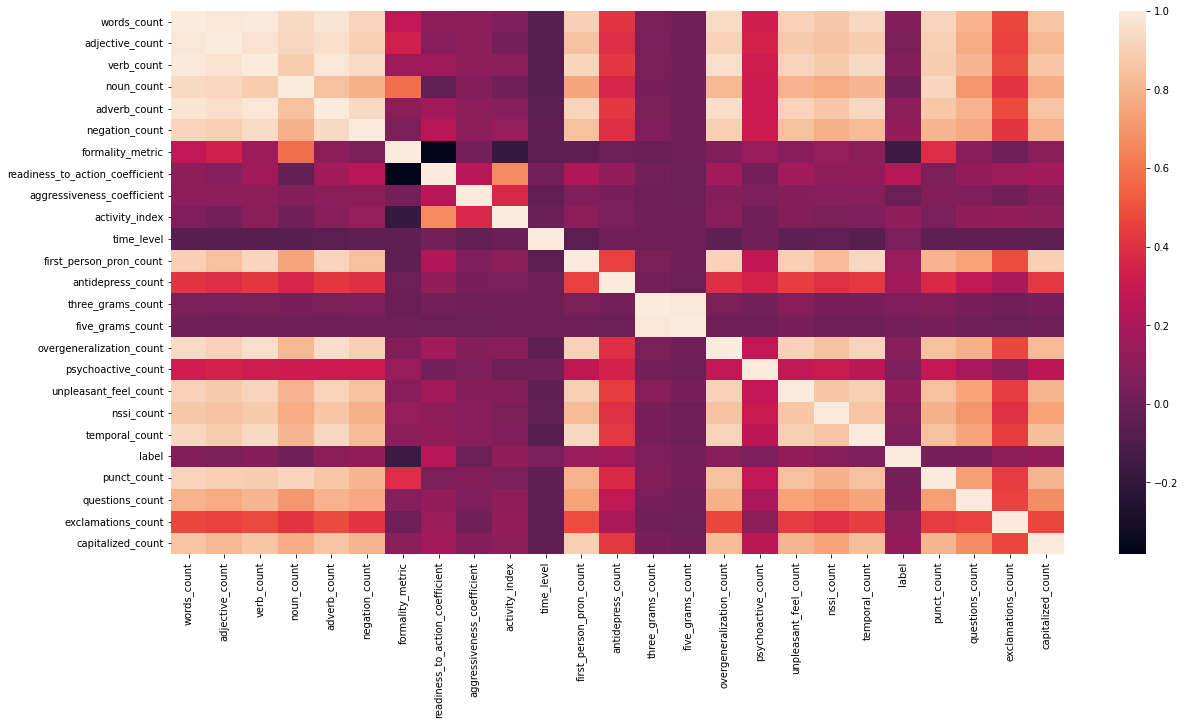

In [253]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 10))
corr_positive = full_dataframe.corr()

sns.heatmap(corr_positive, 
        xticklabels=corr_positive.columns,
        yticklabels=corr_positive.columns)